### Lab 3: Multivariate and logistic regression

## 0. Import packages

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression as LinearRegressionSKL
import matplotlib.pyplot as plt
import random
import sys
from typing import override

## 1. Helper functions

In [2]:
# Helper function to plot the single variable regression data
def plot_single_regression(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    plt.plot(xt, yp, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [3]:
# Helper function to plot the single variable regression data, for multiple solutions
def plot_single_regression_v(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    for ypi in yp:
        plt.plot(xt, ypi, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [4]:
# Helper function to plot the single variable data
def plot_single_data(xf, yf, xt, yt):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = "red")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [5]:
# Helper function to split dataset
# PRE X.shape[0] == y.shape[0]
def split_dataset(X, y, fit_percent=0.7):
    
    split_row = int(X.shape[0] * fit_percent)  
    xf = X[0:split_row, :] 
    yf = y[0:split_row, :] 
    xt = X[split_row:, :]
    yt = y[split_row:, :]
    return xf, yf, xt, yt

In [6]:
# Helper function to add ones as a column to the left of the matrix
def add_ones_left(X):
    return np.column_stack((np.ones_like(X[:,0]), X))

In [7]:
# Helper function to split the target vector of the matrix (last column)
# WARNING: only works when there is only one target per feature
def split_features_target(data):
    X = data[:, :-1]
    y = data[:, data.shape[1] - 1].reshape(-1,1) # reshape to keep matrix-like format (2D instead of 1D)
    return X, y

In [8]:
# Helper function to split dataset randomly
# PRE X.shape[0] == y.shape[0]
def split_dataset_rng(X, y, fit_percent=0.7, seed=0):
    rng = np.random.default_rng(seed) # 0 = random seed
    data = np.column_stack((X, y))
    rng.shuffle(data)

    X, y = split_features_target(data)
    return split_dataset(X, y, fit_percent)

## 2. IModel hierarchy 

In [9]:
from abc import ABC, abstractmethod
from typing import *
from numpy.typing import NDArray

class IModel(ABC):

    @abstractmethod
    def fit(X : NDArray, y : NDArray) -> None:
        '''
        X is a 2D array with n features accross columns and m data points across rows.
        y is a column vector with m labels, one for each data point in X.
        '''
        pass
    
    @abstractmethod
    def predict(xp : NDArray) -> NDArray:
        '''
        xp is a column vector with k data points, each with n features.
        returns a vector with k predicted labels, one for each data point in vector xp.
        '''
        pass

    
    @abstractmethod
    def theta() -> [None | NDArray]:
        '''
        returns the vector theta with k coefficients after model trained.
        before training returns None
        '''
        pass


In [10]:
class Predictor (IModel):
    '''
    Implements the Normal equation model without regularization
    '''

    #Constructor
    def __init__(self) -> None:
        self._theta = None

    # mean square error
    def mse(self, X_test: NDArray, y_test: NDArray) -> float:
        m = X_test.shape[0]
        h = self.predict(X_test)
        r = h - y_test

        return ((r.T @ r) / m)[0][0]

    #predict after training
    def predict(self, xp : NDArray) -> NDArray:
        if self._theta is None:
            raise Exception('It is needed to fit model first')
        else:    
            # add a column of 1s 
            xp = self._addOnesLeft(xp)

            # prediction
            return xp.dot(self._theta)

    
    # return values for theta found after training or None
    def theta(self) -> [None | NDArray]:
        return self._theta

    
    # add a column of 1s at the left
    def _addOnesLeft(self, X:NDArray) -> NDArray:
        return np.column_stack((np.ones_like(X[:,0]), X))

In [11]:
class NormalEQ (Predictor):
    '''
    Implements the Normal equation model without regularization
    '''

    #         T     -1    T
    # Θ = ( X . X  )   . X  y
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
        # add a column of 1s
        X = super()._addOnesLeft(X)
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        self._theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)


In [12]:
class LinearRegression (NormalEQ):
    '''
    Implements multivariate linear regression without regularization, based on the Normal equation model

    just an alias for class NormalEQ
    '''
    pass

In [13]:
class RegularizedModel (Predictor):
    '''
    Represents a model that is regularized with a lambda regularization hperparameter
    '''
    
    def __init__(self, reg_lambda: float) -> None:
        self.set_lambda(reg_lambda)
        super().__init__()

    
    def find_optimal_lambda(self, X_train: NDArray, y_train: NDArray, X_test: NDArray, y_test: NDArray,
                           lambda_range: Tuple[float, float], resolution: float) -> Tuple[float, Tuple[NDArray, NDArray]]:
        num_iterations = int(np.rint((lambda_range[1] - lambda_range[0]) / resolution))
        all_mse = np.empty(shape=(num_iterations, 2))
        old_lambda = self._lambda
        
        best_lambda = lambda_range[0]
        best_lambda_mse = np.inf
        self._lambda = lambda_range[0]
        iter = 0
        while self._lambda < lambda_range[1] and iter < num_iterations:
            self.fit(X_train, y_train)
            curr_mse = self.mse(X_test, y_test)
            if best_lambda_mse > curr_mse:
                best_lambda = self._lambda
                best_lambda_mse = curr_mse
            all_mse[iter, 0] = self._lambda
            all_mse[iter, 1] = curr_mse
            self._lambda += resolution
            iter += 1

        self._lambda = old_lambda
        return best_lambda, all_mse.T

    def set_lambda(self, reg_lambda: float) -> None:
        if reg_lambda < 0:
            raise Exception('lambda must be >= 0')
        self._lambda = reg_lambda

In [14]:
class NormalEQReg (RegularizedModel):
    '''
    Implements the Normal equation model with regularization
    '''

    def __init__(self, l:int) -> None:
        super().__init__(l)

    
    #https://dev.to/_s_w_a_y_a_m_/linear-regression-using-normal-equation-21co
    #
    #         T          -1     T
    # Θ = ( X . X  + λ R)   . X  y   
    #
    # Where R is an Identity matrix where λ(0,0) = 0
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
           
        # add a column of 1s
        X = super()._addOnesLeft(X)

        # setup regularization
        R = np.identity(X.shape[1])
        R[0,0] = 0
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        projection_y = (X.T).dot(y)
        cov          = np.linalg.pinv(X.T.dot(X) + np.multiply(self._lambda, R)) 
        self._theta  = cov.dot(projection_y)

## 3. Quiz solution

---
1.	Express the gradient descent update with regularization in vector form:



starting from the gradient descent update $ \textbf{without} $ regularization, we have

$$
\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha \frac{1}{m} \mathbf{X}^T\mathbf{r}
$$

The only difference should be in the $ \boldsymbol{\theta} $ term, in which it should be applied the regularization.
To achieve this, we can firstly abstract the regularization, replacing it with $ \textbf{s} $:

$$
\boldsymbol{\theta} = \boldsymbol{\theta}s - \alpha \frac{1}{m} \mathbf{X}^T\mathbf{r}
$$

Notice also that the expression $ (1 - \alpha \frac{\lambda}{m})  $ will be constant for a given update of thetas, at which it can be said it is a scalar. This means that $ \boldsymbol{\theta} $ can be simply expressed by

$$
s = (1 - \alpha \frac{\lambda}{m})
$$

and as such, the final expression, replacing $ s $ would be

$$
\boldsymbol{\theta} = (1 - \alpha \frac{\lambda}{m})\boldsymbol{\theta} - \alpha \frac{1}{m} \mathbf{X}^T\mathbf{r}
$$

---
2.	Load the dataset in the companion file $\textbf{demodataset.csv}$. Shuffle it and divide it into disjoint
training and testing datasets.


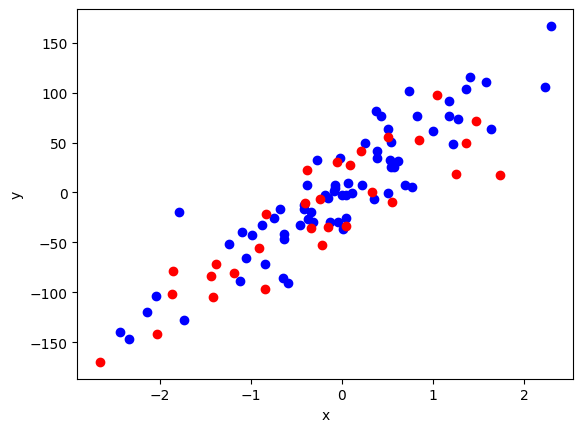

In [15]:
demo_dataset = np.loadtxt("demodataset.csv", delimiter=",")
#seed = random.randint(0, sys.maxsize)
#seed = 1781569127924730678
seed = 5955710078688920750

X, y = split_features_target(demo_dataset)
# X = add_ones_left(X)
X_train, y_train, X_test, y_test = split_dataset_rng(X, y, 0.7, seed)

training_dataset = np.column_stack((X_train, y_train))
testing_dataset = np.column_stack((X_test, y_test))

plot_single_data(X_train, y_train, X_test, y_test)

---
3. a) Implement a linear (in the parameters) basis function regression model using the Gradient descent model with regularization, with a new $ \textbf{Classifier} $ subclass named $\textbf{GradDescReg}$.


In [16]:
class Classifier (Predictor):
    '''
    Implements a classifier model
    '''
    
    def __init__(self) -> None:
        super().__init__()

    @staticmethod
    def sigmoid(z: float) -> float:
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_d(z: float) -> float:
        sig_z = sigmoid(z)
        return sig_z * (1 - sig_z)

    def classify(self, X: NDArray) -> NDArray:
        if self._theta is None:
            raise Exception('It is needed to fit model first')
        else:    
            X = self._addOnesLeft(X)
            return self.sigmoid(X.dot(self._theta))


In [17]:
class GradDescReg (RegularizedModel, Classifier): # Diamond pattern, is fine because of MRO.
    '''
    Implements Gradient Descent with regularization
    '''

    # constructor
    def __init__(self, max_iters: int = 1000, min_conv_diff: float = 10**-8, learning_rate: float = 0.001, reg_lambda_: float = 0.0) -> None:
        self._max_iters = max_iters
        self._min_conv_diff = min_conv_diff
        self._alpha = learning_rate
        super().__init__(reg_lambda=reg_lambda_)


    # applies gradient descent with regularization
    def fit(self, X : NDArray, y : NDArray) -> None:
        # add a column of 1s
        X_full = super()._addOnesLeft(X)

        # initialize weights
        self._theta = np.zeros(X_full.shape[1]).reshape(-1, 1)

        # setup learning rate
        lr = self._alpha / X_full.shape[0]
        
        # setup regularization
        reg = 1 - self._lambda * lr
        
        epoch = 0
        conv_diff = self._min_conv_diff + 1
        while (epoch < self._max_iters and conv_diff > self._min_conv_diff):
            
            # setup residuals
            h = self.predict(X)
            r = h - y
        
            # apply gradient descent with regularization (1 epoch)
            new_theta = (reg * self._theta) - (lr * (X_full.T @ r))

            # checks the norm of the difference in thetas and updates theta
            conv_diff = np.linalg.norm(new_theta - self._theta)
            self._theta = new_theta
            
            epoch += 1

---
3. b) Using $\textbf{GradDescReg}$ class, fit the regression model to the training set and predict with
the test dataset, for values of the regularization term λ = [0, 200], with resolution 1.
Plot the mean square error (mse) for the test dataset for all values of λ.
What is the λ that minimizes the mse?

lambda that minimizes mse for current training set: 6.0


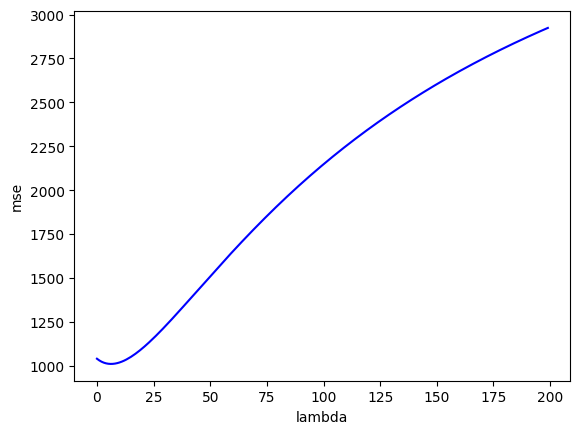

In [18]:
#Solve
grad_desc_reg = GradDescReg(1000, 10**-8, 0.01, 0.1)
best_lambda, all_mse = grad_desc_reg.find_optimal_lambda(X_train, y_train, X_test, y_test, [0, 200], 1.0)
#grad_desc_reg.fit(X, y)
#print(neq.theta())

print(f"lambda that minimizes mse for current training set: {best_lambda}")
#print(all_mse)
plt.plot(all_mse[0], all_mse[1], color = "blue")
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()
#plotSingleRegression(X, y, xp1, yp1)

---
3. c) Plot the train dataset, test datasets, and the regression for the λ that minimizes the mse
obtained in b).

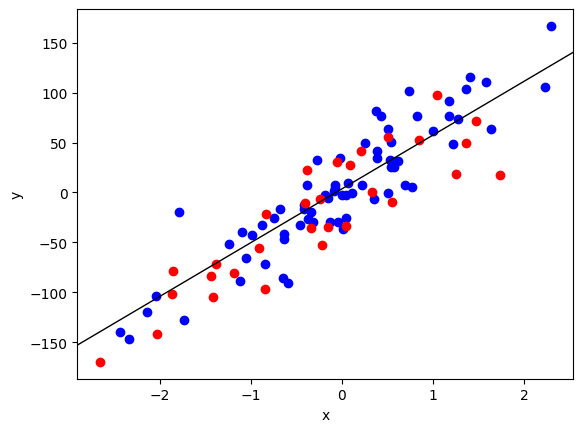

In [19]:
grad_desc_reg.set_lambda(best_lambda)
grad_desc_reg.fit(X_train, y_train)

thetas = grad_desc_reg.theta()
intercept = thetas[0][0]
slope = thetas[1][0]

plt.scatter(X_train, y_train, color = "blue")
plt.scatter(X_test, y_test, color = "red")
plt.axline((0, intercept), slope=slope, color="black", linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

---
3. d) Repeat b) with the $\textbf{NormalEQReg}$ class.

In [20]:
print(seed)

5955710078688920750


lambda that minimizes mse for current training set: 5.0


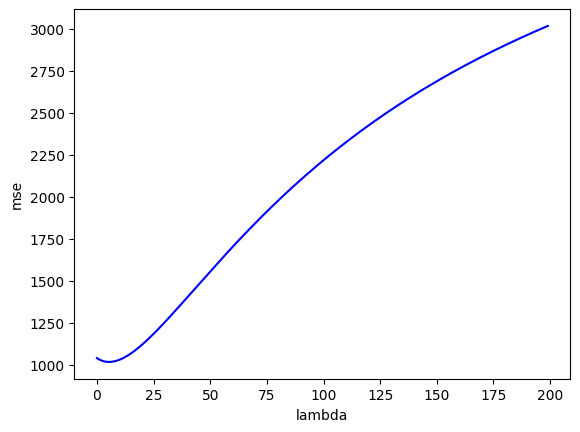

In [21]:
normal_eq_reg = NormalEQReg(0.0)
normal_eq_best_lambda, normal_eq_all_mse = normal_eq_reg.find_optimal_lambda(X_train, y_train, X_test, y_test, [0, 200], 1.0)

print(f"lambda that minimizes mse for current training set: {normal_eq_best_lambda}")
plt.plot(normal_eq_all_mse[0], normal_eq_all_mse[1], color = "blue")
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

---
3. e) Compare the results in c) and d)

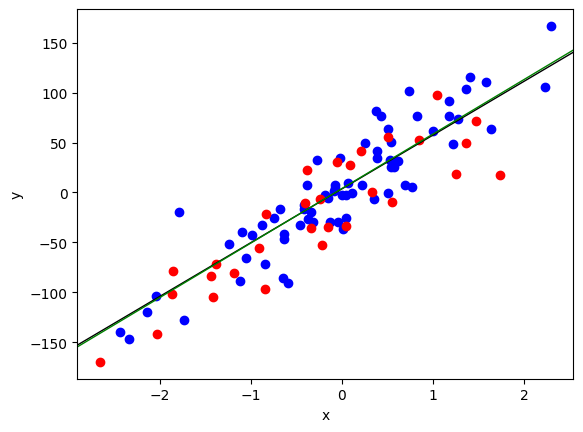

In [22]:
normal_eq_reg.set_lambda(normal_eq_best_lambda)
normal_eq_reg.fit(X_train, y_train)

normal_eq_thetas = normal_eq_reg.theta()
normal_eq_intercept = normal_eq_thetas[0][0]
normal_eq_slope = normal_eq_thetas[1][0]

plt.scatter(X_train, y_train, color = "blue")
plt.scatter(X_test, y_test, color = "red")
plt.axline((0, intercept), slope=slope, color="black", linewidth=1)
plt.axline((0, normal_eq_intercept), slope=normal_eq_slope, color="green", linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As can be seen in the graph above, both Gradient Descent (black) and the Normal Equation (green) reach almost the exact same line (for their optimal lambda).

We also notice by comparing the graphs from d) and from b) that both the Gradient Descent and the Normal Equation models benefit from a regularization hyperparameter (lambda) of \~6, (\~5 for the Normal equation)

---
3. e) Propose a dataset {(x1(i),x2(i), y(i)) | i=1,…, 4} where x1 and x2 are independent binary variables
and y is a linearly separable dependent binary variable. Apply logistic regression and compute the
estimated probability of y = 1 when x1 = x2 = 0.5.

We can take the OR function as a dataset for a linearly separable function:

| x1 | x2 | y |
|----|----|---|
| 0  | 0  | 0 |
| 0  | 1  | 1 |
| 1  | 0  | 1 |
| 1  | 1  | 1 |

In [23]:
X_or = np.array([[0, 0],
             [0, 1],
             [1, 0],
             [1, 1]])

y_or = np.array([0, 1, 1, 1]).reshape(-1, 1)

In [24]:
def plot_regression_plane_classifier(X: NDArray, y: NDArray, weights: NDArray, x1_range: Tuple[float, float], x2_range: Tuple[float, float]) -> None:
    # Bias and weights
    bias = weights[0]
    w1 = weights[1]
    w2 = weights[2]

    # Create a mesh grid
    x1 = np.linspace(x1_range[0], x1_range[1], 200)
    x2 = np.linspace(x2_range[0], x2_range[1], 200)
    X1, X2 = np.meshgrid(x1, x2)

    # Function
    Z = Classifier.sigmoid(w1 * X1 + w2 * X2 + bias)

    # Create the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Surface
    surface = ax.plot_surface(X1, X2, Z,
                             cmap='viridis',
                             antialiased=True,
                             rstride=1,
                             cstride=1,
                             alpha=0.9,
                             linewidth=0,
                             shade=True)
    
    # Add labels
    ax.set_xlabel('X1', fontsize=12)
    ax.set_ylabel('X2', fontsize=12)
    ax.set_zlabel('y', fontsize=12)
    
    # Smooth rotation and viewing angle
    #ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()

In [25]:
class GradDesc (Predictor):
    '''
    Implements Logistic Regression
    '''

    # constructor
    def __init__(self, max_iters: int = 1000, min_conv_diff: float = 10**-8, learning_rate: float = 0.001) -> None:
        self._max_iters = max_iters
        self._min_conv_diff = min_conv_diff
        self._alpha = learning_rate
        super().__init__()

    # applies gradient descent
    def fit(self, X: NDArray, y: NDArray) -> None:
        # add a column of 1s
        X_full = super()._addOnesLeft(X)

        # initialize weights
        self._theta = np.zeros(X_full.shape[1]).reshape(-1, 1)

        # setup learning rate
        lr = self._alpha / X_full.shape[0]

        epoch = 0
        conv_diff = self._min_conv_diff + 1
        while (epoch < self._max_iters and conv_diff > self._min_conv_diff):
            old_theta = self._theta
                    
            # setup residuals
            h = self.predict(X)
            r = h - y
        
            # apply gradient descent with regularization (1 epoch)
            self._theta = self._theta - lr * (X_full.T @ r)
            
            # checks the norm of the difference in thetas and updates theta
            conv_diff = np.linalg.norm(self._theta - old_theta)
            
            epoch += 1

In [26]:
class LogisticRegression (GradDesc, Classifier): # Diamond
    '''
    Implements Logistic Regression
    '''

    # constructor
    def __init__(self, max_iters: int = 1000, min_conv_diff: float = 10**-8, learning_rate: float = 0.001) -> None:
        super().__init__(max_iters, min_conv_diff, learning_rate)

    # Override predict
    def predict(self, X: NDArray) -> NDArray:
        return self.classify(X)

In [27]:
class LogisticRegressionReg (GradDescReg): # Diamond
    '''
    Implements Logistic Regression with Regularization
    '''

    # constructor
    def __init__(self, max_iters: int = 1000, min_conv_diff: float = 10**-8, learning_rate: float = 0.001, reg_lambda: float = 0.0) -> None:
        super().__init__(max_iters, min_conv_diff, learning_rate, reg_lambda)

    # Override predict
    def predict(self, X: NDArray) -> NDArray:
        return self.classify(X)

estimated probabilities of y=1 for:
(x1, x2)
(0, 0) = 0.02
(0, 1) = 0.99
(1, 0) = 0.99
(1, 1) = 1.0

(0.5, 0.5) = 0.99


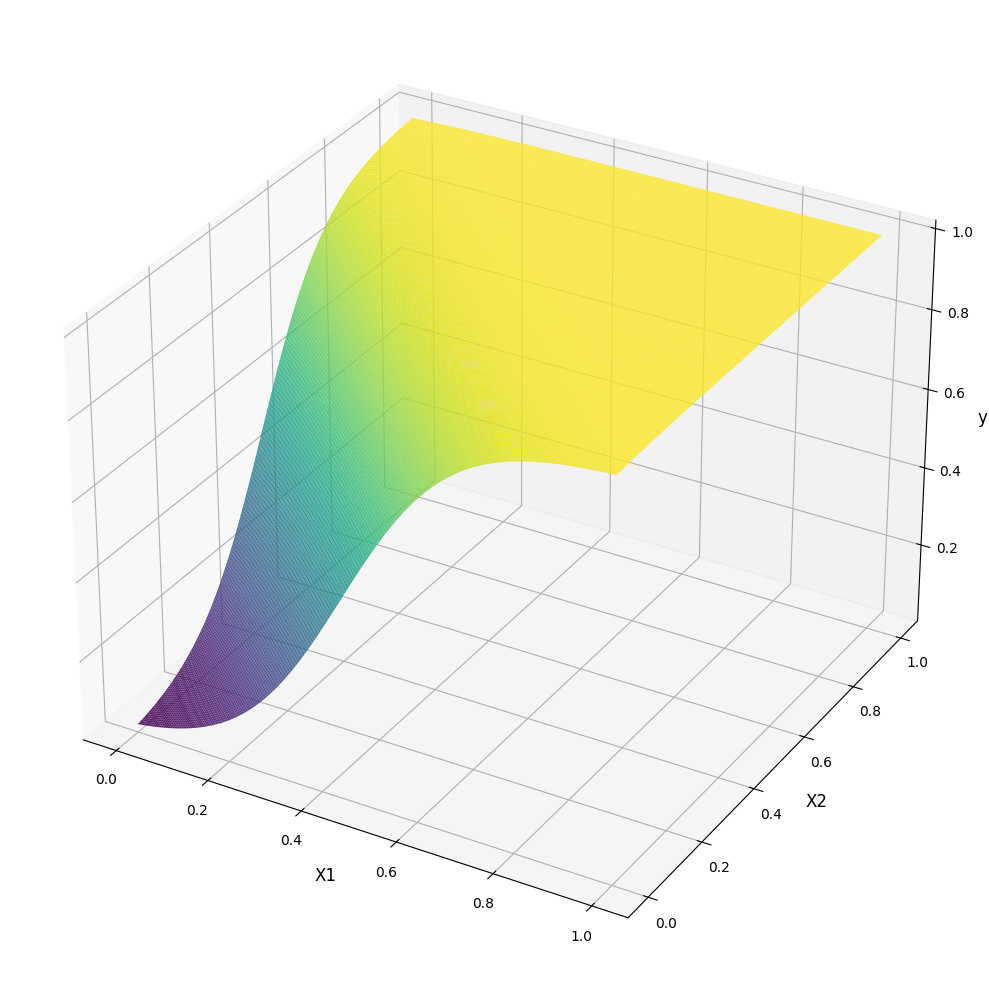

In [28]:
logistic_regression = LogisticRegression(10000, 10**-8, 0.1)
logistic_regression.fit(X_or, y_or)

print("estimated probabilities of y=1 for:")
print("(x1, x2)")
print(f"(0, 0) = {np.round(logistic_regression.predict(np.array([[0, 0]]))[0][0], decimals=2)}")
print(f"(0, 1) = {np.round(logistic_regression.predict(np.array([[0, 1]]))[0][0], decimals=2)}")
print(f"(1, 0) = {np.round(logistic_regression.predict(np.array([[1, 0]]))[0][0], decimals=2)}")
print(f"(1, 1) = {np.round(logistic_regression.predict(np.array([[1, 1]]))[0][0], decimals=2)}")
print()
print(f"(0.5, 0.5) = {np.round(logistic_regression.predict(np.array([[0.5, 0.5]]))[0][0], decimals=2)}")

logistic_thetas = logistic_regression.theta()
plot_regression_plane_classifier(X_or, y_or, logistic_thetas, [0, 1], [0, 1])

---
5. Load the companion data file $\textbf{lab03data.csv}$ in the format {(x1(i),x2(i), y(i)) | i=1,…, m} where x1
and x2 are the independent variables and y denotes the corresponding class.

In [29]:
lab_dataset = np.loadtxt("lab03data.csv", delimiter=",")

---
5. a) Plot the 2 available classes in the space x1, x2

In [30]:
def plot_data_plane(X, y):
    fig = plt.figure()
    
    #plot dataset 
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y, marker='o')
    
    # Plot the regression plane
    ax.view_init(elev=30, azim=10)
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_zlabel("y")

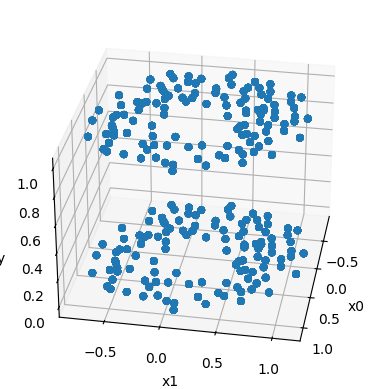

In [31]:
X_lab, y_lab = split_features_target(lab_dataset)
plot_data_plane(X_lab, y_lab)

---
5. b) Apply regularized logistic regression using the following feature vector: [$1$  $x1$  $x2$  $x1^2$
 $x1$ * $x2$  $x2^2$  $x1^3$  …  $x1^5$*$x2$  $x2^6$]’ (28 elements overall) – see the companion file $\textbf{map.py}$ –
and a suitable λ value. Visualize the boundary decision

In [32]:
# map.py
def mapFeature(X1, X2, degree=6):
    '''
    Expands the 2 input features X1 and X2 to polynomial features
    
    Returns a new feature array with the expansion :
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, ...

    Inputs X1, X2 must be Numpy 2D arrays of the same size
    '''

    m = X1.shape[0]
    out = np.ones((m,1))
    
    for i in range (1,degree+1):
        for j in range(0,i+1):
            v = (X1**(i-j))*(X2**j)
            out = np.c_[out, v]
    return out

best lambda: 0.05


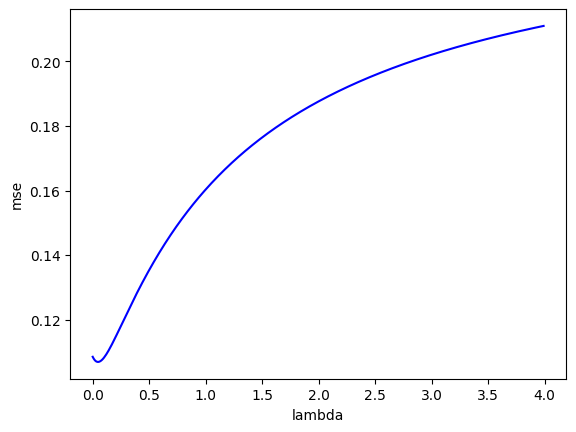

In [33]:
X1 = lab_dataset[:,0].reshape(-1, 1)
X2 = lab_dataset[:,1].reshape(-1, 1)
lab_dataset_expanded = mapFeature(X1, X2)

X_train, y_train, X_test, y_test = split_dataset_rng(lab_dataset_expanded, y_lab, 0.7, seed)

lrr = LogisticRegressionReg(10000, 10**-8, 0.1, 0.0)
lrr_best_lambda, llr_mse = lrr.find_optimal_lambda(X_train, y_train, X_test, y_test, [0, 4], 0.01)

print(f"best lambda: {lrr_best_lambda}")

plt.plot(llr_mse[0], llr_mse[1], color = "blue")
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

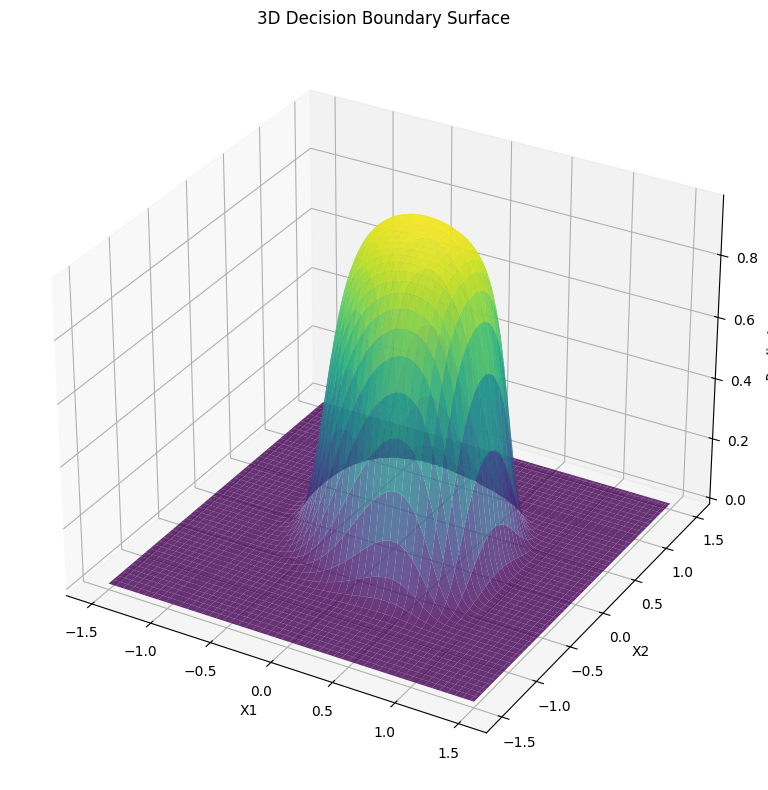

In [34]:
lrr.set_lambda(lrr_best_lambda)
lrr.fit(lab_dataset_expanded, y_lab)

# The features are literally mapped from a 2D feature, so we can just check for the 2D feature
# going for each value of x1 and x2, and mapping to the 28-dimensional space
# :3

# Create a meshgrid of X1 and X2 values (the only ones we need, the original 2D feature space)
x1_range = np.linspace(-1.5, 1.5, 100)
x2_range = np.linspace(-1.5, 1.5, 100)
X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)

Z = np.zeros(X1_mesh.shape)

# Compute predictions for each point in the grid
for i in range(X1_mesh.shape[0]):
    for j in range(X1_mesh.shape[1]):
        X1_val = np.array([[X1_mesh[i, j]]])
        X2_val = np.array([[X2_mesh[i, j]]])
        X_mapped = mapFeature(X1_val, X2_val) # compute the 28D mapping of the 2D feature, which is where the llr is trained
        Z[i, j] = lrr.predict(X_mapped)[0][0] # :D


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X1_mesh, X2_mesh, Z, 
                         cmap='viridis', alpha=0.8,
                         linewidth=0, antialiased=True)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Prediction')
ax.set_title('3D Decision Boundary Surface')

plt.tight_layout()
plt.show()